In [8]:
import numpy as np
import h5py, glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
from pandas.plotting import table 
IT73_quality_cuts = []# ['IceTop_reco_succeeded', 'Laputop_FractionContainment'] #pick which Quality Cuts you want to apply
run_years = np.arange(2011, 2022, 1)
path_to_arrays = '/data/user/slehrman/s125arrays' #update to correct directory

#determining station cuts
#for 2021 station cuts will be tier3_min_station=<tier3 nstations<tier4_min_station and tier4_min_station=<tier4 nstations
#for 2011 station cuts will be tier2_min_station=<tier2 nstations<(tier3_min_station + (1/years_to_increase * 11))....

tier2_min_station = 5 #this is the tier2 energy minimum cut for 2011
tier3_min_station_2021 = 5 #this is the tier2 energy minimum cut for 2021
tier4_min_station_2021 = 12 #this is the tier4 energy minimum cut for 2021
years_to_increase_cut = 2 #for example, every 2 years cut increases by 1, so 2021 tier 3 is 5-12, but 2019 tier 3 is 6-13

In [9]:
#this block loads the s125, stations, and zenith arrays that were created above
for run_year in run_years:
    globals()['s125_'+str(run_year)] = np.load('{}/s125_{}.npy'.format(path_to_arrays, run_year), 'r')
    globals()['stations_'+str(run_year)] = np.load('{}/stations_{}.npy'.format(path_to_arrays, run_year), 'r')
    globals()['zenith_' + str(run_year)] = np.load('{}/zenith_{}.npy'.format(path_to_arrays, run_year), 'r')
   # print(len(globals()['s125_'+str(run_year)]), len(globals()['stations_'+str(run_year)]), len(globals()['zenith_' + str(run_year)]))

In [10]:
#this block applies the IT73 quality cuts that you input at the top
for run_year in run_years:
    finalcut = np.ones(len(globals()['s125_'+str(run_year)]), dtype=int)
    for IT73_quality_cut in IT73_quality_cuts:
        globals()[IT73_quality_cut+'_cut'] = np.load('{}/{}_{}.npy'.format(path_to_arrays, IT73_quality_cut, str(run_year)))
        for i in range(len(globals()[IT73_quality_cut+'_cut'])):
            if globals()[IT73_quality_cut+'_cut'][i] == 0:
                finalcut[i] = 0
    globals()['s125_'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(finalcut==1)]
    globals()['stations_'+str(run_year)] = globals()['stations_'+str(run_year)][np.where(finalcut==1)]
    globals()['zenith_'+str(run_year)] = globals()['zenith_'+str(run_year)][np.where(finalcut==1)]

In [11]:
#eliminating nan and inf events, and applying the zenith quality cut
for run_year in run_years:
    zenith_cut = np.deg2rad(55)
    #print(run_year, len(globals()['s125_'+str(run_year)]), len(globals()['stations_'+str(run_year)]))
    globals()['stations_'+str(run_year)] = globals()['stations_'+str(run_year)][np.where(~np.isnan(globals()['s125_'+str(run_year)]))]
    globals()['zenith_'+str(run_year)] = globals()['zenith_'+str(run_year)][np.where(~np.isnan(globals()['s125_'+str(run_year)]))]
    globals()['s125_'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(~np.isnan(globals()['s125_'+str(run_year)]))]
    
    globals()['stations_'+str(run_year)] = globals()['stations_'+str(run_year)][np.where(np.isfinite(globals()['s125_'+str(run_year)]))]
    globals()['zenith_'+str(run_year)] = globals()['zenith_'+str(run_year)][np.where(np.isfinite(globals()['s125_'+str(run_year)]))]
    globals()['s125_'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(np.isfinite(globals()['s125_'+str(run_year)]))]
    
    globals()['s125_'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(globals()['zenith_' + str(run_year)] < zenith_cut)]
    globals()['stations_'+str(run_year)] = globals()['stations_'+str(run_year)][np.where(globals()['zenith_' + str(run_year)] < zenith_cut)]
    #print(run_year, len(globals()['s125_'+str(run_year)]), len(globals()['stations_'+str(run_year)]))
 

In [12]:
#this block applys the nstation cuts to create the different energy tiers
cuts = []

reversed_run_years = reversed(run_years)
i = 0
for run_year in reversed_run_years:
    if run_year == 2021:
        tier3_min_station = tier3_min_station_2021
        tier4_min_station = tier4_min_station_2021
    if i == years_to_increase_cut: #this if statement increases the station cut boundries going back in the increment specified by years_to_increase
        tier3_min_station +=1
        tier4_min_station += 1
        i = 0
    globals()['tier4'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(globals()['stations_'+str(run_year)] >= tier4_min_station)]
    globals()['tier3'+str(run_year)] = globals()['s125_'+str(run_year)][np.where((globals()['stations_'+str(run_year)] >= tier3_min_station) & (globals()['stations_'+str(run_year)] < tier4_min_station))]
      
    i += 1
    
    if run_year in [2011, 2012, 2013, 2014, 2015]:
        globals()['tier2'+str(run_year)] = globals()['s125_'+str(run_year)][np.where((globals()['stations_'+str(run_year)] >= tier2_min_station) & (globals()['stations_'+str(run_year)] < tier3_min_station))]
        display_tier2_cuts = '{} ≤ bins < {}'.format(tier2_min_station, tier3_min_station)
    else:
        globals()['tier2'+str(run_year)] = 0
        display_tier2_cuts =''
    display_tier3_cuts = '{} ≤ bins < {}'.format(tier3_min_station, tier4_min_station) #this is for displaying the station cuts on the table
    display_tier4_cuts = 'bins ≥ {}'.format(tier4_min_station) 
    cuts.append([display_tier2_cuts, display_tier3_cuts, display_tier4_cuts])

cuts = reversed(cuts)
tab = dict(zip(run_years, cuts))   
df = pd.DataFrame.from_dict(tab, orient='index', columns = pd.MultiIndex.from_product([['Stations Cuts'], ['Tier 2', 'Tier 3', 'Tier 4']]))
display(df) #this is a prettier way to display the table when using jupyter

'''
fig, ax = plt.subplots(figsize= (12, 15)) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set(frame_on = False)

table(ax, df, loc='center')  # where df is your data frame

fig.savefig('stations.png', bbox_inches='tight')
'''

Stations Cuts                           
             Tier 2          Tier 3     Tier 4
2011  5 ≤ bins < 10  10 ≤ bins < 17  bins ≥ 17
2012   5 ≤ bins < 9   9 ≤ bins < 16  bins ≥ 16
2013   5 ≤ bins < 9   9 ≤ bins < 16  bins ≥ 16
2014   5 ≤ bins < 8   8 ≤ bins < 15  bins ≥ 15
2015   5 ≤ bins < 8   8 ≤ bins < 15  bins ≥ 15
2016                  7 ≤ bins < 14  bins ≥ 14
2017                  7 ≤ bins < 14  bins ≥ 14
2018                  6 ≤ bins < 13  bins ≥ 13
2019                  6 ≤ bins < 13  bins ≥ 13
2020                  5 ≤ bins < 12  bins ≥ 12
2021                  5 ≤ bins < 12  bins ≥ 12

"\nfig, ax = plt.subplots(figsize= (12, 15)) # no visible frame\nax.xaxis.set_visible(False)  # hide the x axis\nax.yaxis.set_visible(False)  # hide the y axis\nax.set(frame_on = False)\n\ntable(ax, df, loc='center')  # where df is your data frame\n\nfig.savefig('stations.png', bbox_inches='tight')\n"

In [13]:
#this block finds the number of events, median, mean, and standard deviation for each tier
number_of_events = []
tier2_total = 0
tier3_total = 0
tier4_total =0
total_total= 0


for run_year in run_years:
    globals()['log_tier3'+str(run_year)] = np.log10(globals()['tier3'+str(run_year)])
    globals()['tier3_mean'+str(run_year)] = np.mean(globals()['log_tier3'+str(run_year)])
    globals()['tier3_std'+str(run_year)] = np.std(globals()['log_tier3'+str(run_year)])
    globals()['tier3_median'+str(run_year)] = np.median(globals()['log_tier3'+str(run_year)])
    
    globals()['log_tier4'+str(run_year)] = np.log10(globals()['tier4'+str(run_year)])
    globals()['tier4_mean'+str(run_year)] = np.mean(globals()['log_tier4'+str(run_year)])
    globals()['tier4_std'+str(run_year)] = np.std(globals()['log_tier4'+str(run_year)])
    globals()['tier4_median'+str(run_year)] = np.median(globals()['log_tier4'+str(run_year)])

    
    tier3_total += len(globals()['log_tier3'+str(run_year)])
    tier4_total += len(globals()['log_tier4'+str(run_year)])
    total_total += len(globals()['log_tier3'+str(run_year)])
    total_total += len(globals()['log_tier4'+str(run_year)])
    
    if run_year in [2011, 2012, 2013, 2014]:
        globals()['log_tier2'+str(run_year)] = np.log10(globals()['tier2'+str(run_year)])
        globals()['tier2_mean'+str(run_year)] = np.mean(globals()['log_tier2'+str(run_year)])
        globals()['tier2_std'+str(run_year)] = np.std(globals()['log_tier2'+str(run_year)])
        globals()['tier2_median'+str(run_year)] = np.median(globals()['log_tier2'+str(run_year)])
        
        tier2_total += len(globals()['log_tier2'+str(run_year)])
        total_total += len(globals()['log_tier2'+str(run_year)])

  
        number_of_events.append([len(globals()['tier2'+str(run_year)]), len(globals()['tier3'+str(run_year)]), len(globals()['tier4'+str(run_year)]), 
                            str(len(globals()['tier3'+str(run_year)])+len(globals()['tier2'+str(run_year)])+len(globals()['tier4'+str(run_year)]))])
    else:
        number_of_events.append(['', len(globals()['tier3'+str(run_year)]), len(globals()['tier4'+str(run_year)]), 
                            str(len(globals()['tier3'+str(run_year)])+len(globals()['tier4'+str(run_year)]))])
display_run_years = np.append(run_years, 'total')
number_of_events.append([tier2_total, tier3_total, tier4_total, total_total])
        
tab = dict(zip(display_run_years, number_of_events))  
df1 = pd.DataFrame.from_dict(tab, orient='index', columns = (['Tier 2', 'Tier 3', 'Tier 4', 'Total']))

display(df1) #this is a prettier way to display the table when using jupyter

'''
fig1, ax1 = plt.subplots(figsize= (12, 15)) # no visible frame
ax1.xaxis.set_visible(False)  # hide the x axis
ax1.yaxis.set_visible(False)  # hide the y axis
ax1.set(frame_on = False)
table(ax1, df1, loc='center')  # where df is your data frame

fig1.savefig('number_of_events.png', bbox_inches='tight')
'''

,Tier 2,Tier 3,Tier 4,Total
2011,11589487,1547731,320982,13458200
2012,10026306,1966184,349578,12342068
2013,8523183,1629892,280450,10433525
2014,6591028,1996765,284902,8872695
2015,,1871902,260932,2132834
2016,,2148132,243087,2391219
2017,,2352380,260861,2613241
2018,,2768844,236592,3005436
2019,,1953209,162270,2115479
2020,,3453773,214104,3667877


"\nfig1, ax1 = plt.subplots(figsize= (12, 15)) # no visible frame\nax1.xaxis.set_visible(False)  # hide the x axis\nax1.yaxis.set_visible(False)  # hide the y axis\nax1.set(frame_on = False)\ntable(ax1, df1, loc='center')  # where df is your data frame\n\nfig1.savefig('number_of_events.png', bbox_inches='tight')\n"

In [14]:
def sn(number, sig_fig=1):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + " * 10^" + str(b)



cuts = []
tierdisplay = []
number_of_events = []
tier2_total = 0
tier3_total = 0
tier4_total =0
total_total= 0

reversed_run_years = reversed(run_years)
i = 0
for run_year in reversed_run_years:
    if run_year == 2021:
        tier3_min_station = tier3_min_station_2021
        tier4_min_station = tier4_min_station_2021
    if i == years_to_increase_cut:
        tier3_min_station +=1
        tier4_min_station += 1
        i = 0
    globals()['tier4'+str(run_year)] = globals()['s125_'+str(run_year)][np.where(globals()['stations_'+str(run_year)] >= tier4_min_station)]
    globals()['tier3'+str(run_year)] = globals()['s125_'+str(run_year)][np.where((globals()['stations_'+str(run_year)] >= tier3_min_station) & (globals()['stations_'+str(run_year)] < tier4_min_station))]
  
    i += 1
    
    if run_year in [2011, 2012, 2013, 2014]:
        globals()['tier2'+str(run_year)] = globals()['s125_'+str(run_year)][np.where((globals()['stations_'+str(run_year)] >= tier2_min_station) & (globals()['stations_'+str(run_year)] < tier3_min_station))]
        display_tier2_cuts = '{} ≤ n < {}'.format(tier2_min_station, tier3_min_station)
        display_tier_1cut = '3 ≤ n <5'
    else:
        globals()['tier2'+str(run_year)] = 0
        display_tier2_cuts =''
        display_tier_1cut = ''
        
    display_tier3_cuts = '{} ≤ n < {}'.format(tier3_min_station, tier4_min_station)
    display_tier4_cuts = 'n ≥ {}'.format(tier4_min_station)
    cuts.append([display_tier_1cut, display_tier2_cuts, display_tier3_cuts, display_tier4_cuts])
    
    globals()['log_tier3'+str(run_year)] = np.log10(globals()['tier3'+str(run_year)])
    globals()['tier3_mean'+str(run_year)] = np.mean(globals()['log_tier3'+str(run_year)])
    globals()['tier3_std'+str(run_year)] = np.std(globals()['log_tier3'+str(run_year)])
    globals()['tier3_median'+str(run_year)] = np.median(globals()['log_tier3'+str(run_year)])
    
   # globals()['tier4'+str(year)] = globals()['tier4'+str(year)][np.where(~np.isnan(globals()['tier4'+str(year)]))]
    #globals()['tier4'+str(year)][np.where(np.isfinite(globals()['tier4'+str(year)]))]
    globals()['log_tier4'+str(run_year)] = np.log10(globals()['tier4'+str(run_year)])
    globals()['tier4_mean'+str(run_year)] = np.mean(globals()['log_tier4'+str(run_year)])
    globals()['tier4_std'+str(run_year)] = np.std(globals()['log_tier4'+str(run_year)])
    globals()['tier4_median'+str(run_year)] = np.median(globals()['log_tier4'+str(run_year)])
    
    if run_year in [2011, 2012, 2013, 2014]:
        globals()['log_tier2'+str(run_year)] = np.log10(globals()['tier2'+str(run_year)])
        globals()['tier2_mean'+str(run_year)] = np.mean(globals()['log_tier2'+str(run_year)])
        globals()['tier2_std'+str(run_year)] = np.std(globals()['log_tier2'+str(run_year)])
        globals()['tier2_median'+str(run_year)] = np.median(globals()['log_tier2'+str(run_year)])
        
        tier2_total += len(globals()['log_tier2'+str(run_year)])
        total_total += len(globals()['log_tier2'+str(run_year)])
  
        number_of_events.append([len(globals()['tier2'+str(run_year)]), len(globals()['tier3'+str(run_year)]), len(globals()['tier4'+str(run_year)]), str(len(globals()['tier3'+str(run_year)])+len(globals()['tier2'+str(run_year)])+len(globals()['tier4'+str(run_year)]))])
    else:
        number_of_events.append(['', len(globals()['tier3'+str(run_year)]), len(globals()['tier4'+str(run_year)]), str(len(globals()['tier3'+str(run_year)])+len(globals()['tier4'+str(run_year)]))])
    
    tier3_total += len(globals()['log_tier3'+str(run_year)])
    tier4_total += len(globals()['log_tier4'+str(run_year)])
    total_total += len(globals()['log_tier3'+str(run_year)])
    total_total += len(globals()['log_tier4'+str(run_year)])
    if run_year in [2011, 2012, 2013, 2014]:
        tierdisplay.append([display_tier_1cut, '',  display_tier2_cuts, sn(len(globals()['tier2'+str(run_year)])), display_tier3_cuts, sn(len(globals()['tier3'+str(run_year)])),
                            display_tier4_cuts, sn(len(globals()['tier4'+str(run_year)])), '', sn((len(globals()['tier3'+str(run_year)])+len(globals()['tier4'+str(run_year)])+len(globals()['tier2'+str(run_year)])))])

    else:
        tierdisplay.append([display_tier_1cut, '', display_tier2_cuts, '', display_tier3_cuts, sn(len(globals()['tier3'+str(run_year)])), display_tier4_cuts,
                        sn(len(globals()['tier4'+str(run_year)])), '', sn(len(globals()['tier3'+str(run_year)])+len(globals()['tier4'+str(run_year)]))])

display_run_years = np.append(run_years, 'Total') 

tierdisplay.insert(0, ['', '', '', sn(tier2_total), '', sn(tier3_total), '', sn(tier4_total), '', sn(total_total)])
tierdisplay = reversed(tierdisplay)

tab = dict(zip(display_run_years, tierdisplay))   

df2 = pd.DataFrame.from_dict(tab, orient='index', columns = pd.MultiIndex.from_product([['Tier 1', 'Tier 2','Tier 3', 'Tier 4', 'Total'], ['Station Cut', '# of events']]))
display(df2) #this is a prettier way to display the table when using jupyter
'''
fig2, ax2 = plt.subplots(figsize = (15,20)) # no visible frame
ax2.xaxis.set_visible(False)  # hide the x axis
ax2.yaxis.set_visible(False)  # hide the y axis
ax2.set(frame_on = False)
table(ax2, df2, loc='center')  # where df is your data frame

fig2.savefig('stations_and_number_of_events.png', bbox_inches='tight')
'''


Tier 1                  Tier 2                   Tier 3  \
      Station Cut # of events Station Cut # of events  Station Cut   
2011     3 ≤ n <5              5 ≤ n < 10  1.2 * 10^7  10 ≤ n < 17   
2012     3 ≤ n <5               5 ≤ n < 9  1.0 * 10^7   9 ≤ n < 16   
2013     3 ≤ n <5               5 ≤ n < 9  8.5 * 10^6   9 ≤ n < 16   
2014     3 ≤ n <5               5 ≤ n < 8  6.6 * 10^6   8 ≤ n < 15   
2015                                                    8 ≤ n < 15   
2016                                                    7 ≤ n < 14   
2017                                                    7 ≤ n < 14   
2018                                                    6 ≤ n < 13   
2019                                                    6 ≤ n < 13   
2020                                                    5 ≤ n < 12   
2021                                                    5 ≤ n < 12   
Total                                      3.7 * 10^7                

                       Tier 4                   Total              
      # of events Station Cut # of events Station Cut # of events  
2011   1.5 * 10^6      n ≥ 17  3.2 * 10^5              1.3 * 10^7  
2012   2.0 * 10^6      n ≥ 16  3.5 * 10^5              1.2 * 10^7  
2013   1.6 * 10^6      n ≥ 16  2.8 * 10^5              1.0 * 10^7  
2014   2.0 * 10^6      n ≥ 15  2.8 * 10^5              8.9 * 10^6  
2015   1.9 * 10^6      n ≥ 15  2.6 * 10^5              2.1 * 10^6  
2016   2.1 * 10^6      n ≥ 14  2.4 * 10^5              2.4 * 10^6  
2017   2.4 * 10^6      n ≥ 14  2.6 * 10^5              2.6 * 10^6  
2018   2.8 * 10^6      n ≥ 13  2.4 * 10^5              3.0 * 10^6  
2019   2.0 * 10^6      n ≥ 13  1.6 * 10^5              2.1 * 10^6  
2020   3.5 * 10^6      n ≥ 12  2.1 * 10^5              3.7 * 10^6  
2021   3.0 * 10^6      n ≥ 12  1.8 * 10^5              3.2 * 10^6  
Total  2.5 * 10^7              2.8 * 10^6              6.4 * 10^7

"\nfig2, ax2 = plt.subplots(figsize = (15,20)) # no visible frame\nax2.xaxis.set_visible(False)  # hide the x axis\nax2.yaxis.set_visible(False)  # hide the y axis\nax2.set(frame_on = False)\ntable(ax2, df2, loc='center')  # where df is your data frame\n\nfig2.savefig('stations_and_number_of_events.png', bbox_inches='tight')\n"

In [8]:
means = []
medians = []
for run_year in run_years:
    display_tier_3_mean = '{:0.2f}'.format(globals()['tier3_mean'+str(run_year)])
    display_tier_4_mean = '{:0.2f}'.format(globals()['tier4_mean'+str(run_year)])
    
    display_tier_3_medianian = '{:0.2f} {} {:0.2f}'.format(globals()['tier3_median'+str(run_year)],  u"\u00B1", globals()['tier3_std'+str(run_year)])    
    display_tier_4_medianian = '{:0.2f} {} {:0.2f}'.format(globals()['tier4_median'+str(run_year)], u"\u00B1", globals()['tier4_std'+str(run_year)])
    
    if run_year in [2011, 2012, 2013, 2014]:
        display_tier_2_mean = '{:0.2f}'.format(globals()['tier2_mean'+str(run_year)])
        display_tier_2_medianian = '{:0.2f} {} {:0.2f}'.format(globals()['tier2_median'+str(run_year)],  u"\u00B1", globals()['tier2_std'+str(run_year)])
    else: 
        display_tier_2_mean = ''
        display_tier_2_medianian = ''
   
    means.append([display_tier_2_mean, display_tier_3_mean, display_tier_4_mean])
    medians.append([display_tier_2_medianian, display_tier_3_medianian, display_tier_4_medianian])
    #medians.append([display_tier_3_medianian, display_tier_4_medianian])
tab = dict(zip(run_years, means))   
df3 = pd.DataFrame.from_dict(tab, orient='index', columns = pd.MultiIndex.from_product([['Mean Log10s125'], ['Tier 2', 'Tier 3', 'Tier4']]))

display(df3) #this is a prettier way to display the table when using jupyter

'''
fig3, ax3 = plt.subplots(figsize = (12, 15)) # no visible frame
ax3.xaxis.set_visible(False)  # hide the x axis
ax3.yaxis.set_visible(False)  # hide the y axis
ax3.set(frame_on = False)
table(ax3, df3, loc='center')  # where df is your data frame
fig3.savefig('means.png', bbox_inches='tight')
'''  
tab = dict(zip(run_years, medians))   
df4 = pd.DataFrame.from_dict(tab, orient='index', columns = pd.MultiIndex.from_product([['Median Log10s125'], ['Tier 2', 'Tier 3', 'Tier 4']]))
display(df4) #this is a prettier way to display the table when using jupyter
'''
fig4, ax4 = plt.subplots(figsize = (12, 15)) # no visible frame
ax4.xaxis.set_visible(False)  # hide the x axis
ax4.yaxis.set_visible(False)  # hide the y axis
ax4.set(frame_on = False)


table(ax4, df4, loc='center')  # where df is your data frame

fig4.savefig('medians.png', bbox_inches='tight')
'''

Mean Log10s125             
             Tier 2 Tier 3 Tier4
2011          -0.23   0.27  0.77
2012          -0.21   0.23  0.75
2013          -0.17   0.28  0.81
2014          -0.14   0.26  0.81
2015                  0.30  0.86
2016                  0.24  0.84
2017                  0.28  0.88
2018                  0.22  0.88
2019                  0.25  0.91
2020                  0.13  0.86
2021                  0.16  0.89

Median Log10s125                          
               Tier 2       Tier 3       Tier 4
2011     -0.24 ± 0.32  0.25 ± 0.28  0.71 ± 0.34
2012     -0.22 ± 0.31  0.21 ± 0.28  0.70 ± 0.34
2013     -0.18 ± 0.31  0.26 ± 0.27  0.75 ± 0.34
2014     -0.15 ± 0.30  0.24 ± 0.28  0.75 ± 0.34
2015                   0.28 ± 0.28  0.80 ± 0.34
2016                   0.23 ± 0.29  0.79 ± 0.34
2017                   0.26 ± 0.28  0.82 ± 0.34
2018                   0.20 ± 0.30  0.82 ± 0.34
2019                   0.23 ± 0.30  0.85 ± 0.34
2020                   0.12 ± 0.32  0.81 ± 0.34
2021                   0.15 ± 0.32  0.84 ± 0.34

"\nfig4, ax4 = plt.subplots(figsize = (12, 15)) # no visible frame\nax4.xaxis.set_visible(False)  # hide the x axis\nax4.yaxis.set_visible(False)  # hide the y axis\nax4.set(frame_on = False)\n\n\ntable(ax4, df4, loc='center')  # where df is your data frame\n\nfig4.savefig('medians.png', bbox_inches='tight')\n"

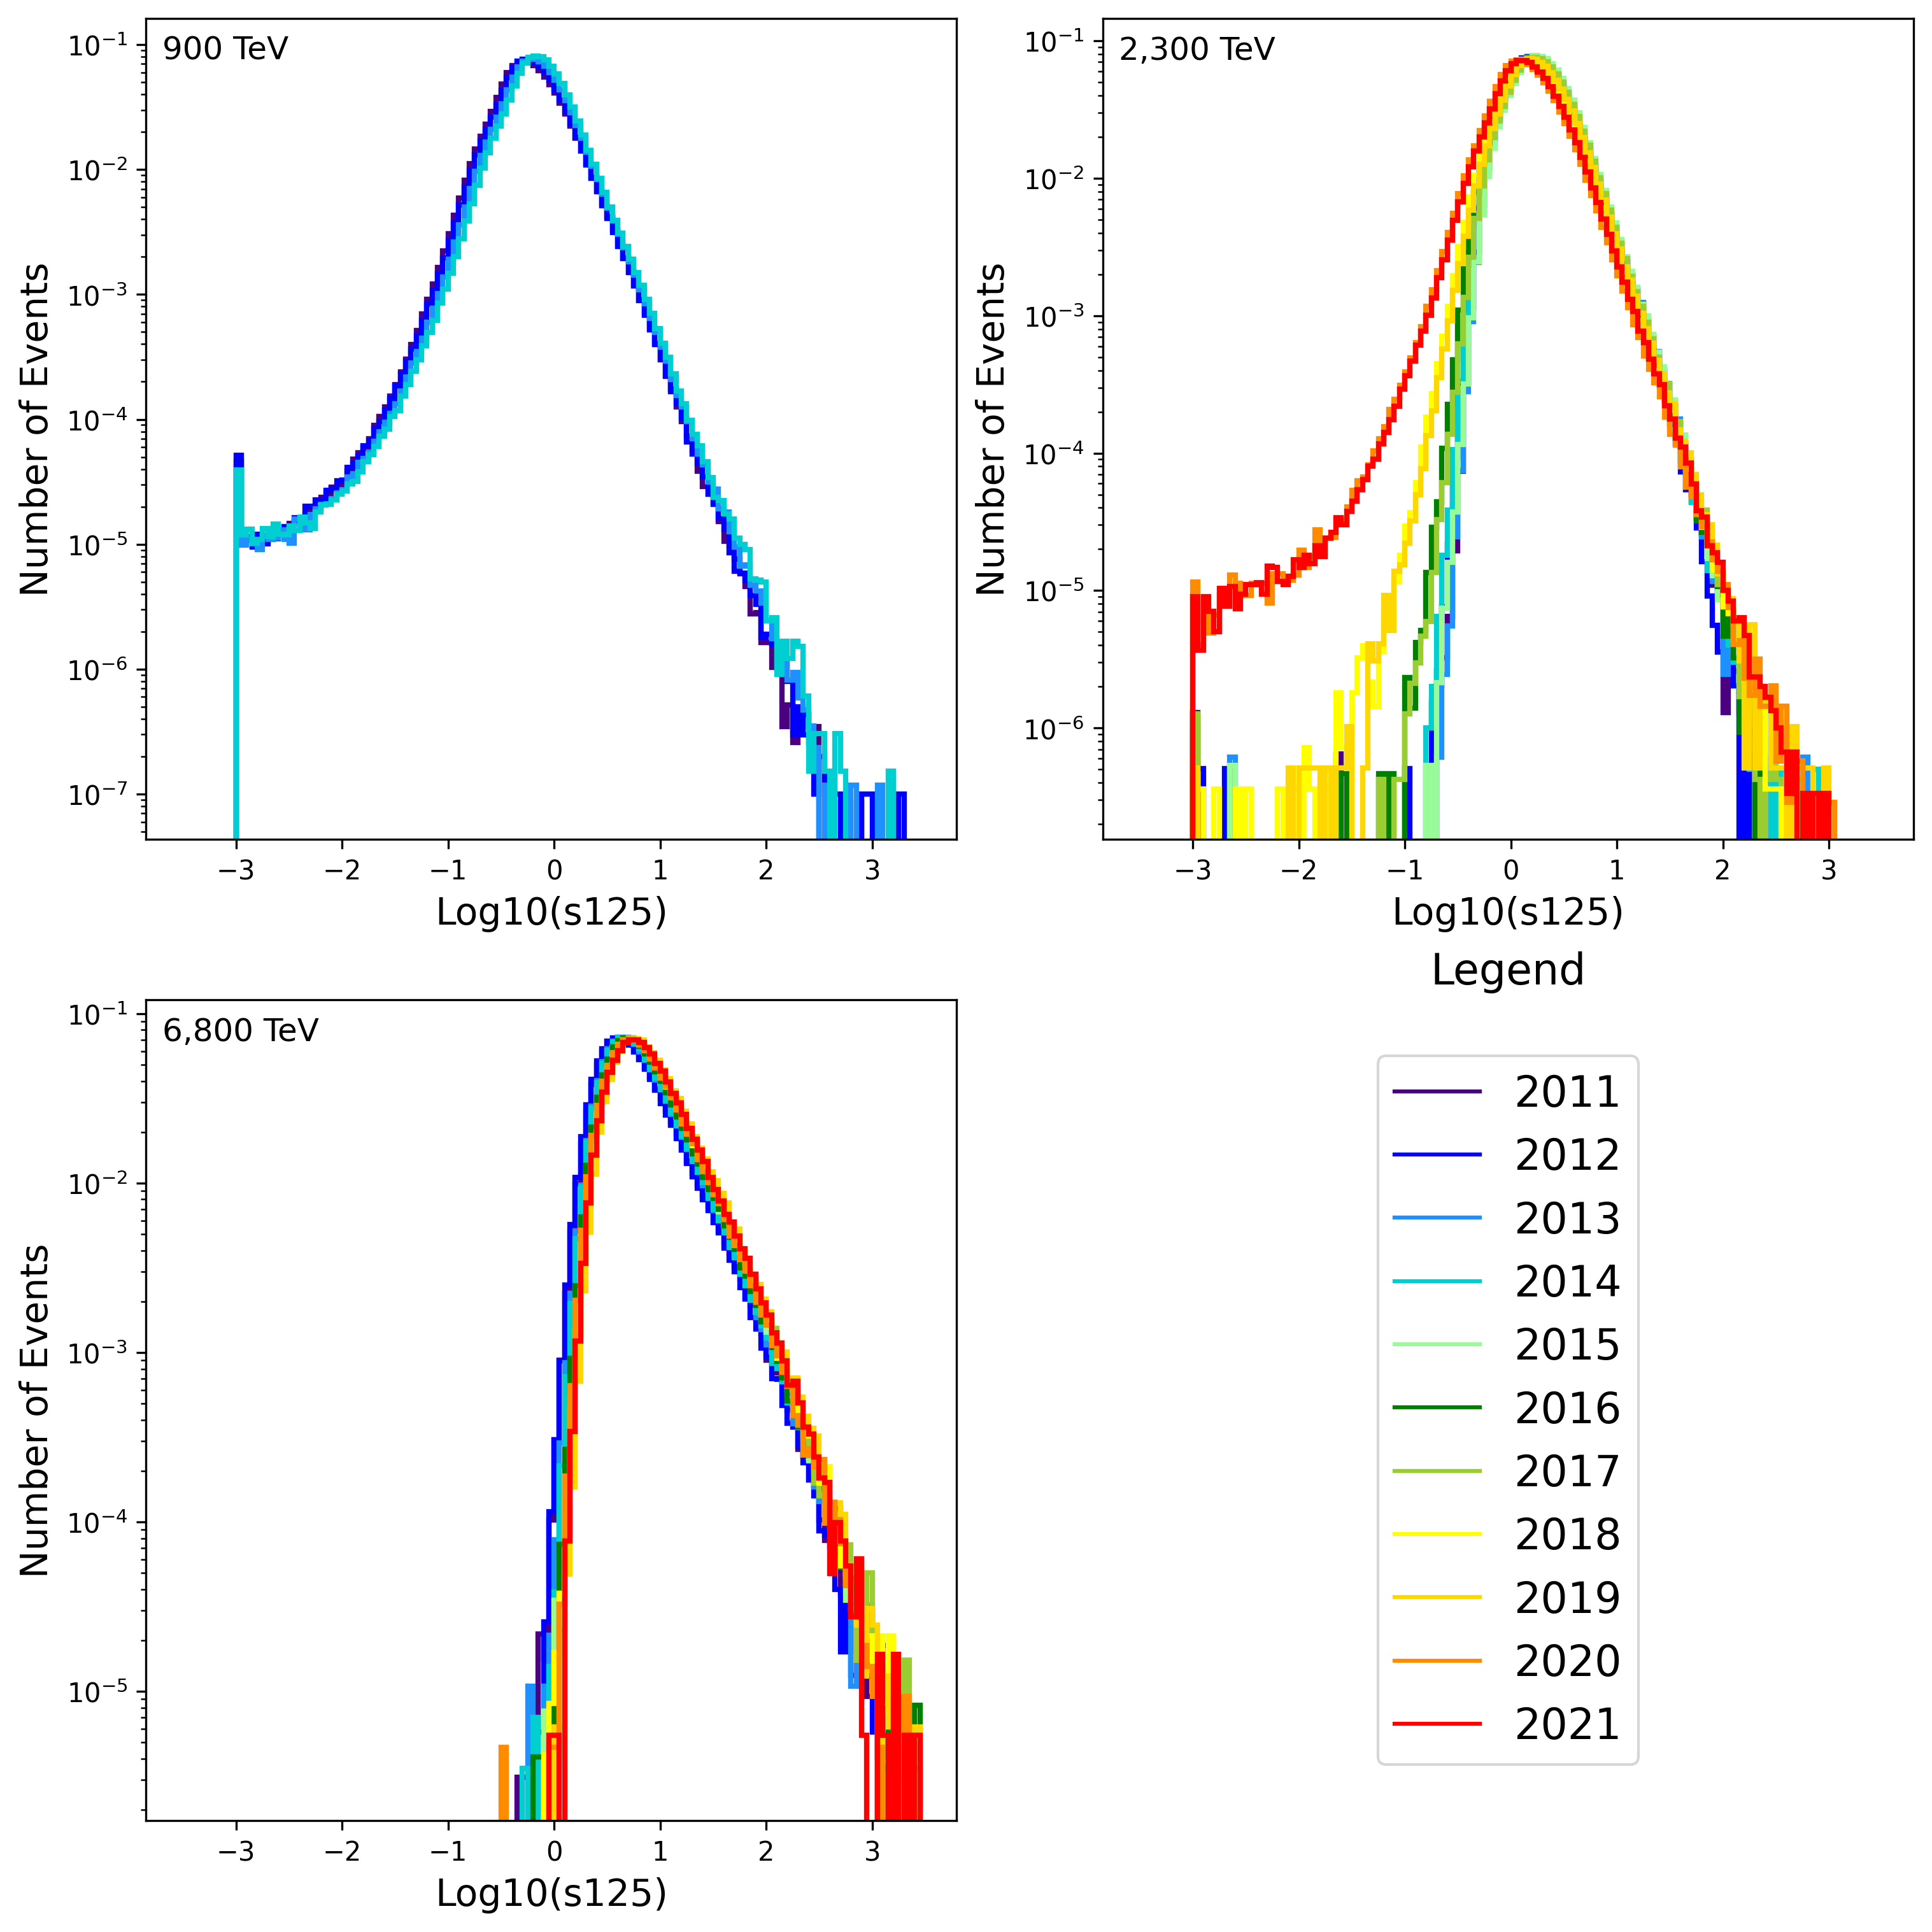

In [21]:
#this block creates the s125 histograms
bins = (np.arange(-3.5, 3.5, .05))
fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True, dpi = 300)
colors = ['indigo', 'blue', 'dodgerblue', 'darkturquoise', 'palegreen', 'green', 'yellowgreen', 'yellow', 'gold', 'darkorange', 'red']
i = 0

for run_year in run_years:
    if run_year in np.arange(2011, 2015, 1):
        axs[0, 0].hist(globals()['log_tier2'+str(run_year)], bins, weights=(np.ones(len(globals()['log_tier2'+str(run_year)])) / len(globals()['log_tier2'+str(run_year)])), histtype='step', label = '{} Tier 2'.format(run_year), linewidth = 2, color = colors[i])
    axs[0,1].hist(globals()['log_tier3'+str(run_year)], bins, weights=np.ones(len(globals()['log_tier3'+str(run_year)])) / len(globals()['log_tier3'+str(run_year)]), histtype='step', label = '{} Tier 3'.format(run_year), linewidth = 2, color = colors[i])
    axs[1, 0].hist(globals()['log_tier4'+str(run_year)], bins, weights=np.ones(len(globals()['log_tier4'+str(run_year)])) / len(globals()['log_tier4'+str(run_year)]), histtype='step', label = '{} Tier 4'.format(run_year), linewidth = 2, color = colors[i])
    axs[1,1].axhline(y = -10, label = run_year, color = colors[i])
    i += 1

# Add engergy lables to each plot
axs[0, 0].text(0.02, 0.98, '900 TeV', transform=axs[0, 0].transAxes, 
               fontsize=12, verticalalignment='top')
axs[0, 1].text(0.02, 0.98, '2,300 TeV', transform=axs[0, 1].transAxes, 
               fontsize=12, verticalalignment='top')
axs[1, 0].text(0.02, 0.98, '6,800 TeV', transform=axs[1, 0].transAxes, 
               fontsize=12, verticalalignment='top')

    
axs[0, 0].semilogy()
axs[0, 0].set_xlabel('Log10(s125)', fontsize = 14)
axs[0, 0].set_ylabel('Number of Events', fontsize =14)


axs[0, 1].semilogy()
axs[0, 1].set_xlabel('Log10(s125)', fontsize = 14)
axs[0, 1].set_ylabel('Number of Events', fontsize =14)


axs[1, 0].semilogy()
axs[1, 0].set_xlabel('Log10(s125)', fontsize = 14)
axs[1, 0].set_ylabel('Number of Events', fontsize =14)


axs[1,1].set_title('Legend', fontsize=16)
axs[1,1].legend(fontsize =16, loc = 'center')
axs[1,1].set_ylim([0, 10])
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)

plt.savefig('s125_histograms.png')
plt.show()